In [4]:
# %pip install causalml --user 
# %pip install catboost
# %pip install ipywidgets
%pip install scikit-uplift


Note: you may need to restart the kernel to use updated packages.


минипроект,посвященный аплифт моделированию.
проверяется сравнительная эффективность нескольких разных моделей на одном датасете.

решается задача классификации.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Импортируем S- и T-learner`ы (BaseSClassifier и BaseTClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# В качестве классификатора воспользуемся моделью градиентного бустинга от Яндекса (CatBoost)
from catboost import CatBoostClassifier
%matplotlib inline

from sklearn.model_selection import train_test_split

# Uplift-дерево и случайный лес
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


Failed to import duecredit due to No module named 'duecredit'


In [2]:

# Прочитаем файл с данными
df = pd.read_csv(r"..\..\chunk\2Y\criteo-uplift-v2.1.csv")


In [3]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


Fields
Here is a detailed description of the fields (they are comma-separated in the file):

f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float) 

treatment: treatment group (1 = treated, 0 = control)

conversion: whether a conversion occured for this user (binary, label)

visit: whether a visit occured for this user (binary, label)

exposure: treatment effect, whether the user has been effectively exposed (binary)

In [5]:
# первичный анализ данных
selected_columns = ['treatment', 'conversion', 'visit', 'exposure']

def piv(cols):
    # Создаем сводную таблицу, используя count() для подсчета наблюдений
    pivot_table = df[selected_columns].pivot_table(index=cols, aggfunc='size').reset_index(name='count')
    # Добавляем столбец с процентами относительно общего числа наблюдений
    pivot_table['percentage'] = (pivot_table['count'] / pivot_table['count'].sum()) * 100

    # Сортируем таблицу по столбцу 'percentage' в порядке убывания
    pivot_table = pivot_table.sort_values(by='percentage', ascending=False)
    # Выводим сводную таблицу
    print(pivot_table)
cols=['treatment', 'conversion', 'visit', 'exposure']
piv(cols)

   treatment  conversion  visit  exposure     count  percentage
3          1           0      0         0  11055129   79.080484
0          0           0      0         0   2016832   14.426973
5          1           0      1         0    385634    2.758550
4          1           0      0         1    250702    1.793343
6          1           0      1         1    154479    1.105032
1          0           0      1         0     76042    0.543950
8          1           1      1         1     23031    0.164747
7          1           1      1         0     13680    0.097857
2          0           1      1         0      4063    0.029064


похоже, что большая часть  (80%) включенных в группу воздействия - не показала какого-либо эффекта с т.з. конверсии;

всего 0.16% из группы воздействия  с эффектом конверсии пользовались подобным промо, а 1.1% пользовались, но на сей раз дело не дошло до конверсии. 
доля лояльных, которые купили безо всякого воздействия составляет 0.02%.

как можно истолковать строки с индексами 7(все единицы, кроме exposure ) и 8(все единицы): возможно , что из группы с воздействием, среди посетителей с конверсией в два раза больше таких(0.16%), которые пользовались раньше промо, чем тех, что не пользовались (0.09%)..., возможно даже, что ~0.09% - это процент новеньких, которые пополняют ряды участников скидочных мероприятий.

In [6]:
cols=['treatment', 'conversion']
piv(cols)

   treatment  conversion     count  percentage
2          1           0  11845944   84.737409
0          0           0   2092874   14.970923
3          1           1     36711    0.262604
1          0           1      4063    0.029064


* **как понимать класс клиента на основе признаков treatment  conversion ** :
    * ~15% **0 - Control Non-Responders(CN)** 
        Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
    * ~0.03% **1 - Control Responders(CR)**
        Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
    * ~84% **2 - Treatment Non-Responders(CN)**
        Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    * ~0.26% **3 - Treatment Responders(CN)** 
    Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

In [4]:
# Определим колонки с факторами
feature_cols = list(set(df.columns)-set(['treatment', 'conversion']))
print(feature_cols)

['f3', 'exposure', 'f4', 'f9', 'f0', 'f5', 'f7', 'f8', 'f1', 'f11', 'f2', 'visit', 'f10', 'f6']


In [5]:
# Разделим данные на тренировочную и тестовую выборки.
df_train, df_test = train_test_split(
    df,     stratify=df[["treatment", "conversion"]], 
    random_state=13, 
    test_size=0.3
)
print(df_train.shape)
print(df_test.shape)

df_train.head()

(9785714, 16)
(4193878, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
13162840,12.616365,10.059654,8.915734,4.679882,10.280525,4.115453,0.294443,4.833815,3.934656,13.190056,5.300375,-0.168679,0,0,0,0
11010165,12.616365,10.059654,8.837421,4.679882,10.280525,4.115453,0.294443,4.833815,3.880455,13.190056,5.300375,-0.168679,1,0,0,0
11795432,12.616365,10.059654,8.253335,4.679882,10.280525,4.115453,0.294443,4.833815,3.899112,21.416100,5.300375,-0.168679,1,0,0,0
7411821,12.616365,10.059654,8.320478,4.679882,10.280525,4.115453,0.294443,4.833815,3.878372,23.570168,5.300375,-0.168679,1,0,0,0
12125581,25.089484,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [6]:
# функция для оценки qini-curve
def qini_df(df,isOnlyScore=False, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['treatment'] == 0)
    N_t = sum(ranked['treatment'] == 1)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[(ranked.treatment == 0) & (ranked.conversion == 1),'n_c1'] = 1
    ranked.loc[(ranked.treatment == 1) & (ranked.conversion == 1),'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    if isOnlyScore:return quni_score
    print('Qini score: {:.3f}'.format(quni_score))
     # визуализация
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
   

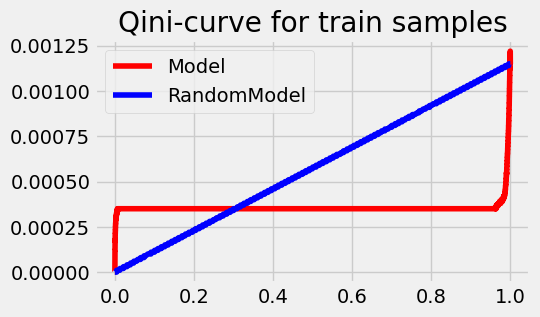

Qini score: -2147.272


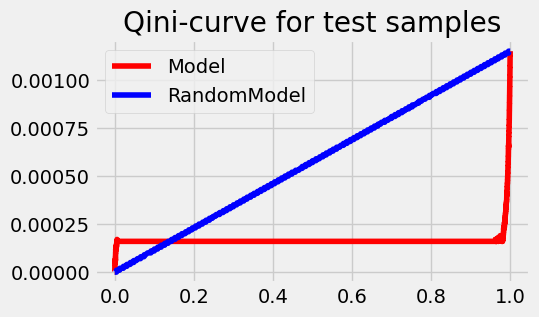

Qini score: -1717.627


In [15]:
# общая функция для расчета/отображения qinicurve для большинства моделей
def buildLearner(_learner):
    # Для обучения нам нужны датафрейм с факторами, колонка с фактом воздействия
    _learner.fit(X=df_train[feature_cols],
                treatment=df_train["treatment"],
                y=df_train["conversion"])

    # Сделаем предсказание uplift-эффекта на обучающей выборке
    uplift_vals = _learner.predict(np.array(df_train[feature_cols].values.copy()))
    df_train['uplift_score'] = uplift_vals

    # Сделаем предсказание uplift-эффекта на тестовой выборке
    uplift_vals = _learner.predict(np.array(df_test[feature_cols].values.copy()))
    df_test['uplift_score'] = uplift_vals

    # Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
    qini_df(df_train, title='train')
    qini_df(df_test, title='test')


# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))
buildLearner(s_learner)


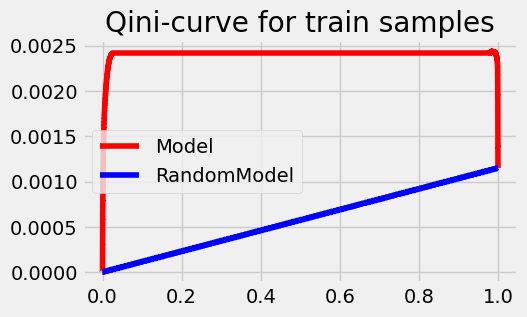

Qini score: 17955.157


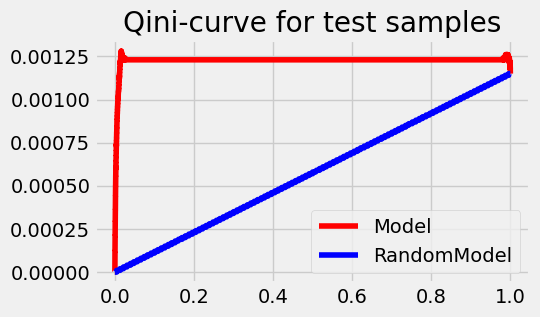

Qini score: 2727.604


In [16]:

# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))
buildLearner(t_learner)



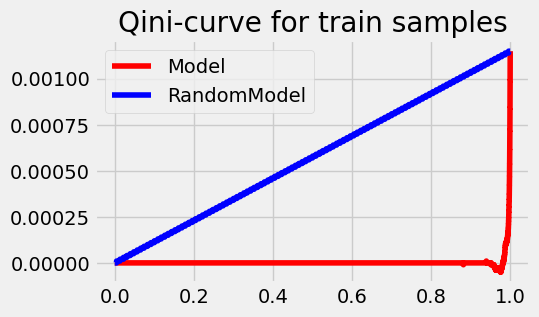

Qini score: -5601.294


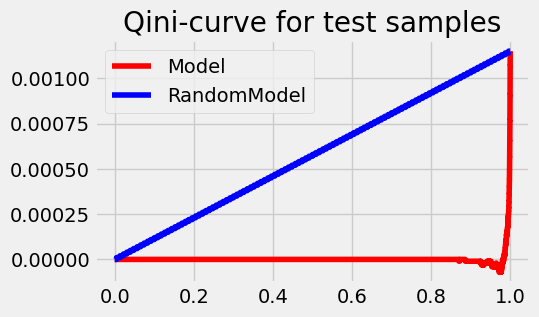

Qini score: -2405.705


In [17]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression()
)
buildLearner(x_learner)

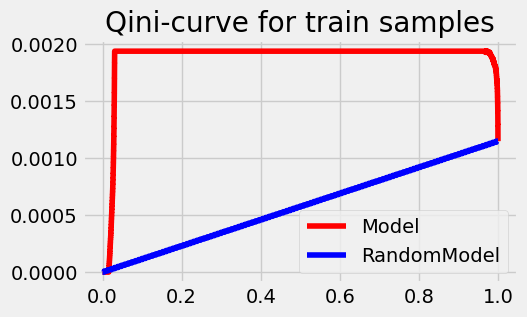

Qini score: 12836.138


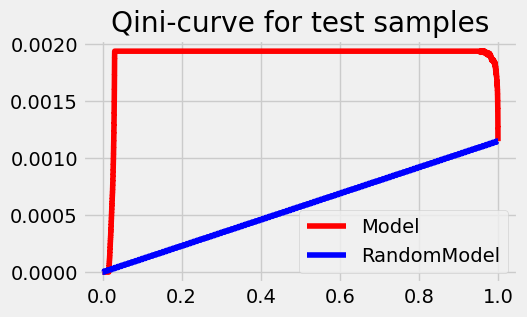

Qini score: 5501.095


In [18]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression(),
    random_state=42
)
buildLearner(r_learner)

### Uplift-tree (CausalML)

Qini score: 3844.883


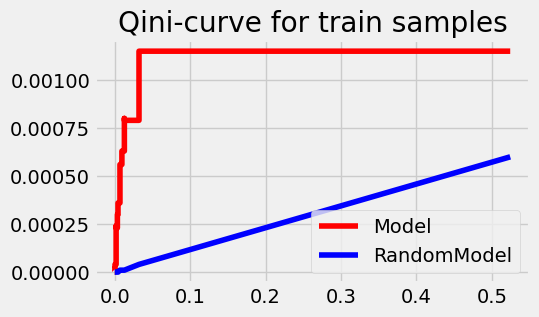

Qini score: 2347.098


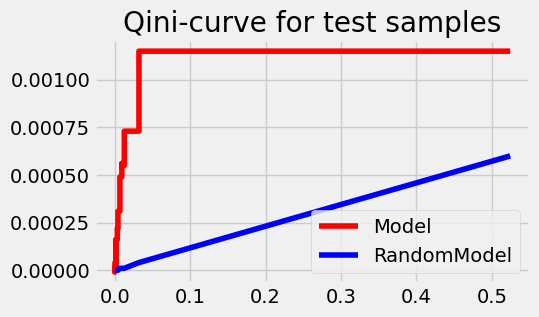

In [33]:
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    df_train[feature_cols].values,
    treatment=df_train["treatment"].apply(str).values,
    y=df_train["conversion"].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_train[feature_cols].values.copy()))[:, 1]
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_test[feature_cols].values.copy()))[:, 1]
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

In [42]:
params = {
    'control_name': uplift_tree.control_name,
    'evaluationFunction': uplift_tree.evaluationFunction,
    'max_depth': uplift_tree.max_depth,
    'min_samples_leaf': uplift_tree.min_samples_leaf,
    'min_samples_treatment': uplift_tree.min_samples_treatment,
    'n_reg': uplift_tree.n_reg,
    'random_state': uplift_tree.random_state
}

print(params)

{'control_name': '0', 'evaluationFunction': <cyfunction UpliftTreeClassifier.evaluate_ED at 0x000001747B317110>, 'max_depth': 5, 'min_samples_leaf': 200, 'min_samples_treatment': 50, 'n_reg': 100, 'random_state': 42}


In [64]:
df_test.sample(5)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,uplift_score
11235579,23.098041,10.059654,8.214383,4.679882,10.280525,4.115453,-11.589224,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.0
322211,23.982525,10.059654,8.888494,4.679882,10.280525,4.115453,-8.693224,4.833815,3.895862,13.190056,5.300375,-0.168679,1,0,0,0,0.0
5044777,24.609949,10.059654,8.214383,4.679882,10.280525,4.115453,-5.116672,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.0
13061249,12.616365,10.059654,8.588771,4.679882,10.280525,4.115453,0.294443,4.833815,3.899112,26.606156,5.300375,-0.168679,0,0,0,0,0.0
11296347,24.595566,10.059654,8.214383,4.679882,10.280525,4.115453,-6.359690,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,0.0


Можем посмотреть на вид построенного дерева. 

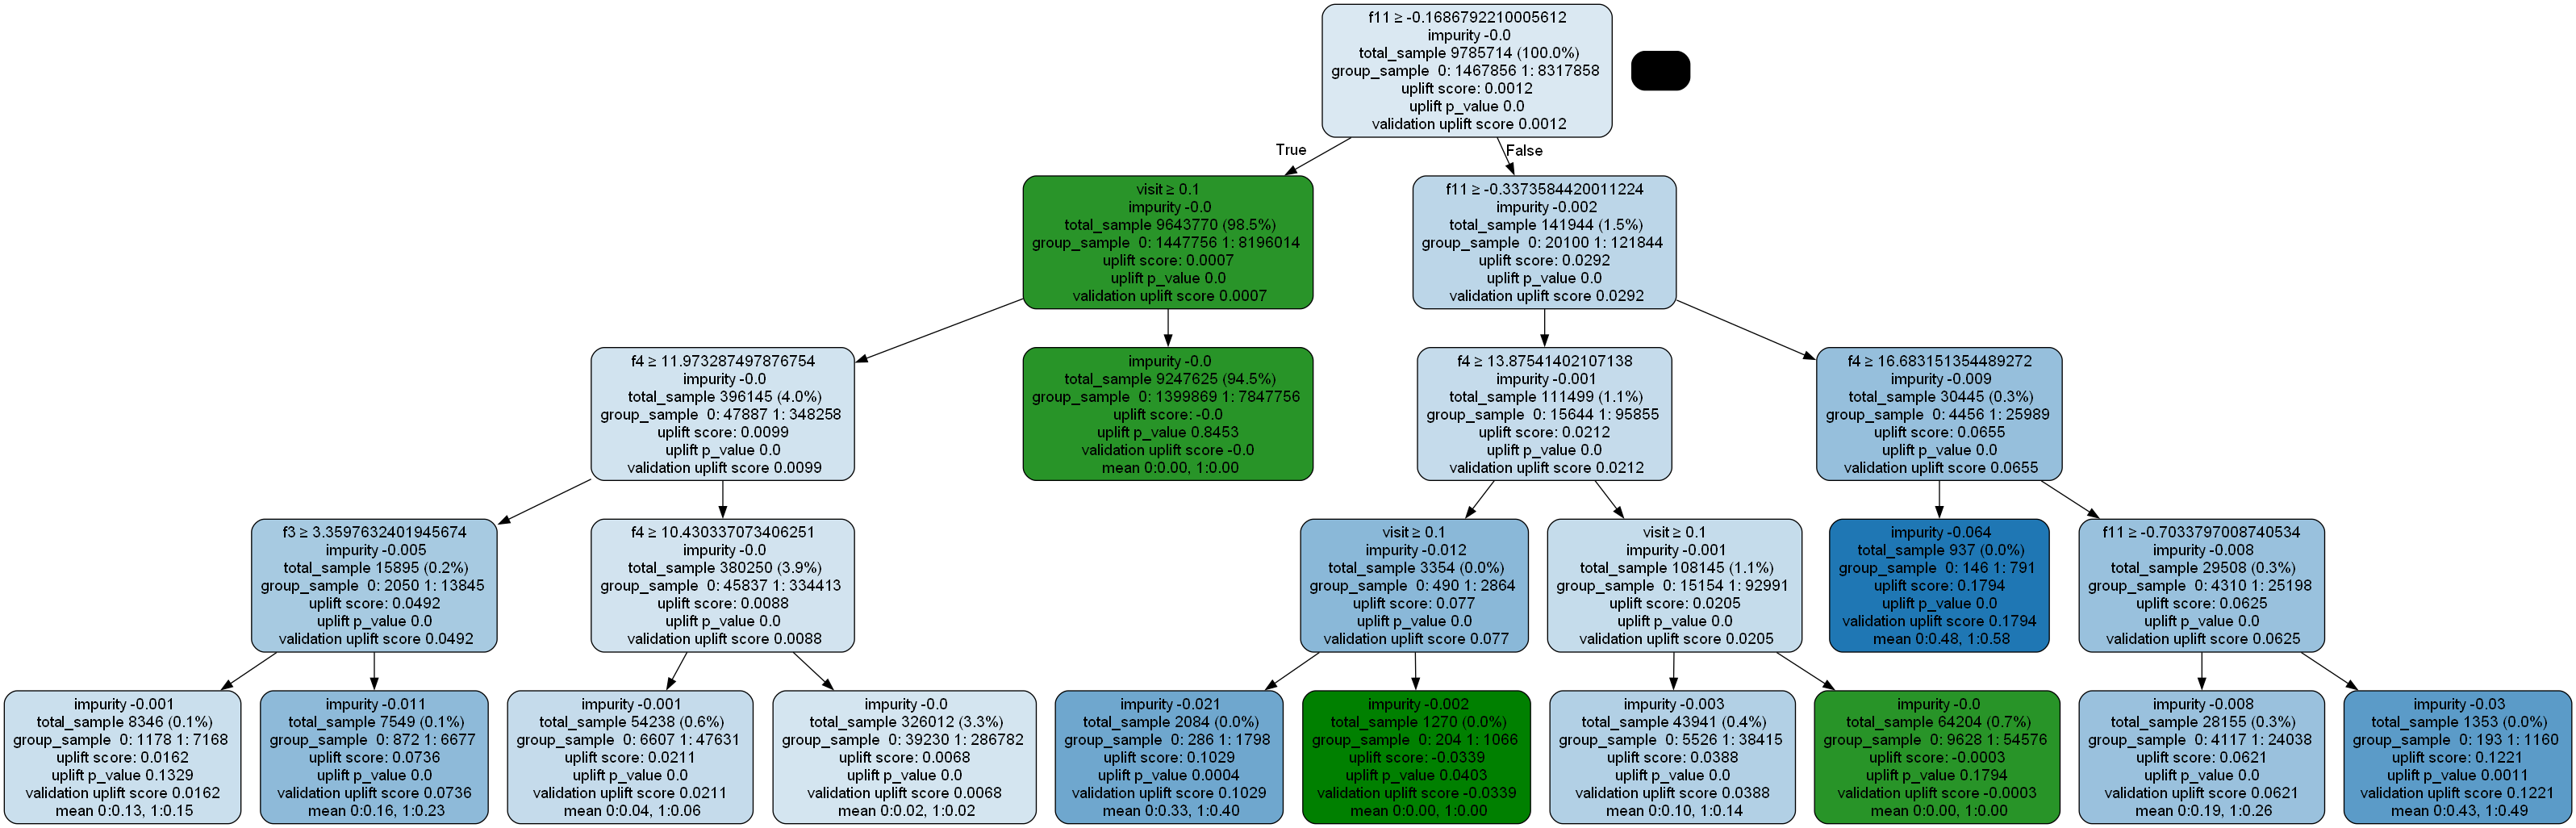

In [24]:
import os

# Получить текущее значение PATH
current_path = os.environ.get('PATH')
# Добавить путь к Graphviz в PATH
os.environ['PATH'] = current_path + ';C:\\Program Files\\Graphviz\\bin'

# Давайте визуализируем наше простейшее дерево
from IPython.display import Image
# Вызываем функцию для визуализации:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

### UpliftRandomForest (CausalML)

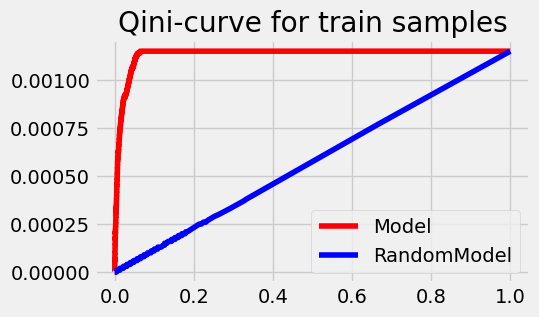

Qini score: 5444.999


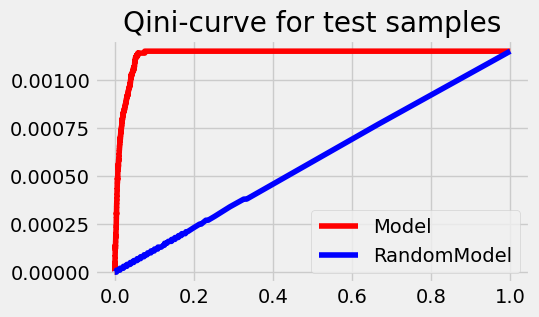

Qini score: 2320.951


In [25]:
# Создаем лес.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=100, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    df_train[feature_cols].values,
    treatment=df_train["treatment"].apply(str).values,
    y=df_train["conversion"].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

In [80]:
%pip install scikit-uplift

Note: you may need to restart the kernel to use updated packages.


построение валидационного датасета

для примера подбора гиперпараметров модели выбран UpliftTreeClassifier, т.к. эта модель относительно быстро работает на исходном датасете.
перебор по сетке занял сутки.

другие модели опробовать с перебором по сетке невозможно из-за отсутствия необходимой вычислительной мощности.

для использования модели с GridSearchCV сделана специальная оболочка, а применение scoring=custom_score потребовало особогой подхода: отложенного выделение treatment

In [5]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
# подготовка трех датасетов(тренировачного, валидационного, тестового)
df_trainval, df_test = train_test_split(
    df,     stratify=df[["treatment", "conversion"]], 
    random_state=13, 
    test_size=0.3
)
df_train, df_val = train_test_split(
    df_trainval,     stratify=df_trainval[["treatment", "conversion"]], 
    random_state=13, 
    test_size=0.3
)


In [34]:

from sklearn.base import BaseEstimator, ClassifierMixin
from sklift.metrics import make_uplift_scorer

# специальный класс-оболочка для использования связки несовместимой со sklearn GridSearchCV моделью causalml UpliftTreeClassifier
class UpliftTreeClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        # self.model = None
        self.model = UpliftTreeClassifier(
            evaluationFunction='ED', 
            control_name='0', random_state=42,**kwargs
        )
        # with open('log.txt', 'a', encoding='cp1251') as f:
        #     f.write(f'__init__ {kwargs}\n')
    
    # treatment передан в составе X (для совместимости с custom_score другого способа не нашлось)
    def fit(self, X,  y=None, **fit_params):
        try:
            treatment = X["treatment"]
            X.drop(["treatment"],axis=1,inplace=True)
            self.model.fit(X.values,  y=y.values, treatment=treatment.apply(str).values)
        except Exception as e:
            with open('log.txt', 'a', encoding='cp1251') as f:
                f.write(f'fit An error occurred: {e}')
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    def get_params(self, deep=True):
        # with open('log.txt', 'a', encoding='cp1251') as f:
        #     f.write(f'get_params {self.kwargs}\n')
        return self.kwargs
    def set_params(self,**params):
        try:
            # with open('log.txt', 'a', encoding='cp1251') as f:
            #     f.write(f'set_params {params}\n')
            self.model = UpliftTreeClassifier(
                evaluationFunction='ED', 
                control_name='0', random_state=42,**params
            )
        except Exception as e:
            with open('log.txt', 'a', encoding='cp1251') as f:
                f.write(f'set_params An error occurred: {e}')
        return self

uplift_model = UpliftTreeClassifierWrapper(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100
)

param_grid = {
    "max_depth": [ 3,5,10],
    "min_samples_leaf": [150,200,300],
    "min_samples_treatment":[25,50,100],
    "n_reg":[50,100,200]
}
# в этот метод никак не получилось передать treatment кроме как в составе с X
def custom_score(estimator, X, y):
    with open('log.txt', 'a', encoding='cp1251') as f:
        f.write(f'custom_score {X.columns} \n')
    treatment = X["treatment"]
    X.drop(["treatment"],axis=1,inplace=True)
    y_df = pd.DataFrame(y, columns=['conversion'])
    treatment_df = pd.DataFrame(treatment, columns=['treatment'])
    df_ = pd.concat([ y_df,treatment_df], axis=1)
    df_['uplift_score'] = estimator.predict(X.copy())[:, 1]
    return qini_df(df_,isOnlyScore=True)
grid_search2 = GridSearchCV(uplift_model, param_grid, cv=5,verbose=4,n_jobs=-1, scoring=custom_score) #
# гиперпараметры подбираются на тренировочном датасете 
grid_search2.fit(
    df_train[feature_cols+["treatment"]],
    y=df_train["conversion"]
)
best_params = grid_search2.best_params_
best_score = grid_search2.best_score_
print(best_params,best_score)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=50;, score=664.897 total time= 1.9min
[CV 2/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=50;, score=794.018 total time= 1.9min
[CV 3/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=50;, score=733.861 total time= 1.9min
[CV 4/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=50;, score=831.768 total time= 1.9min
[CV 5/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=50;, score=746.543 total time= 1.9min
[CV 1/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=100;, score=664.288 total time= 1.9min
[CV 2/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=100;, score=794.018 total time= 1.9min
[CV 3/5] END max_depth=3, min_samples_leaf=150, min_samples_treatment=25, n_reg=100;, score=733.861 total time

Qini score: 1660.290


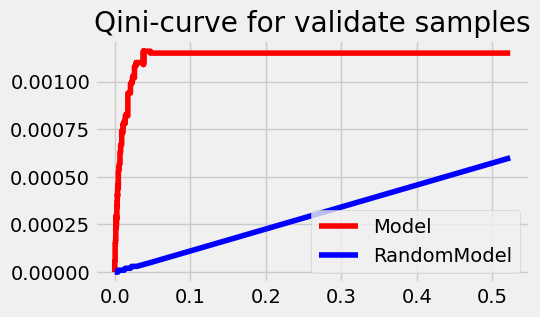

Qini score: 2361.315


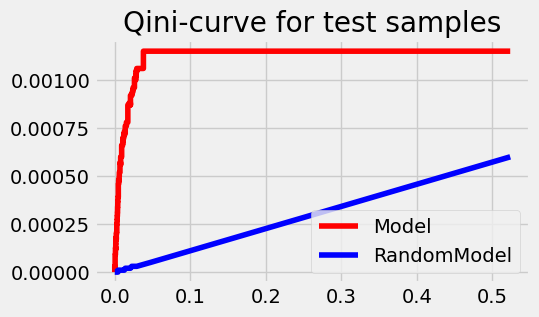

In [35]:


uplift_model_best = UpliftTreeClassifier(evaluationFunction='ED', 
    control_name='0', random_state=42,**best_params)

# модель далее натренирована на валидационном датасете для чистоты исключения взаимовлияния с тренировочным датасетом и подобранными на нем гиперпараметрами
uplift_model_best.fit(df_val[feature_cols].values, 
                    treatment= df_val["treatment"].apply(str).values,
                    y= df_val["conversion"].values)
uplift_vals = uplift_model_best.predict(np.array(df_val[feature_cols].values.copy()))[:, 1]
df_val['uplift_score'] = uplift_vals

uplift_vals = uplift_model_best.predict(np.array(df_test[feature_cols].values.copy()))[:, 1]
df_test['uplift_score'] = uplift_vals

qini_df(df_val, title='validate')
qini_df(df_test, title='test')

# с подобранными по сетке гиперпараметрами кини кривая выглядит более гладко-выпукло, чем 
# вариант фиксированных гиперпараметров для этой же модели UpliftTreeClassifier


# по оценке на основе qini_qurve
базовый S-learner,X-learner показали плохие результаты
T-learner,R-learner,UpliftTreeClassifier,UpliftRandomForestClassifier, - хорошие

# победителем среди моделей можно считать R-learner, который на тестовой выборке показал наибольшее значение Qini score: 5501.095

test: повтор расчета с делением датасета на трейн/тест:

qini результат для тестовой выборки чуть лучше, но практически не отличается от такового для самого первого расчета UpliftTreeClassifier с фиксированными гиперпараметрами(отличными от лучших, выбранных по сетке)

Qini score: 5524.810


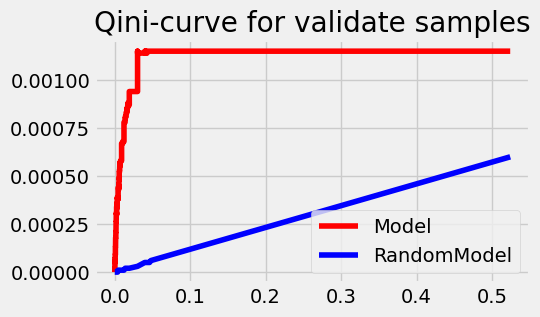

Qini score: 2359.990


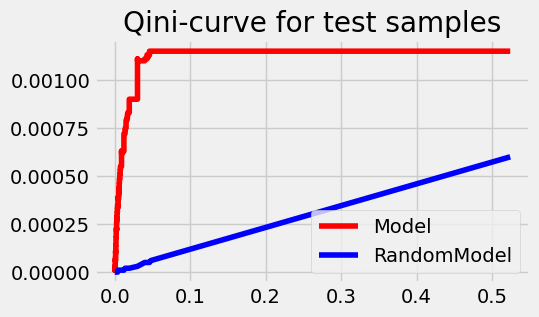

In [10]:
best_params={'max_depth': 10, 'min_samples_leaf': 150, 'min_samples_treatment': 25, 'n_reg': 100}
uplift_model_best = UpliftTreeClassifier(evaluationFunction='ED', 
    control_name='0', random_state=42,**best_params)

# модель далее натренирована на валидационном датасете для чистоты исключения взаимовлияния с тренировочным датасетом и подобранными на нем гиперпараметрами
uplift_model_best.fit(df_train[feature_cols].values, 
                    treatment= df_train["treatment"].apply(str).values,
                    y= df_train["conversion"].values)
uplift_vals = uplift_model_best.predict(np.array(df_train[feature_cols].values.copy()))[:, 1]
df_train['uplift_score'] = uplift_vals

uplift_vals = uplift_model_best.predict(np.array(df_test[feature_cols].values.copy()))[:, 1]
df_test['uplift_score'] = uplift_vals

qini_df(df_train, title='validate')
qini_df(df_test, title='test')